In [1]:
import sys
sys.path.append('../')
from params_f16 import F16Params, Controls
from lin_f16 import get_lin_f16 as linearize
import control as ct
import numpy as np
import matplotlib.pyplot as plt
import control_tools as tools
%matplotlib widget

#### Constants

In [2]:
RTOD = 57.296

In [3]:
params = F16Params()
params.alt_ft = 0.0
params.VT_ftps = 502.0
params.xcg = 0.35
controls = Controls()

In [4]:
_, lat_sys = linearize(controls, params)

Trim results:
Throttle (0-1): 0.26
Elevator (deg): -0.76
Alpha (deg): 2.12
Aileron (deg): 0.00
Rudder (deg): -0.00
Beta (deg): -0.00


In [5]:
IDX_ARRAY = [0,1,3,4]
ap = lat_sys.A[IDX_ARRAY,:][:,IDX_ARRAY]
bp = lat_sys.B[IDX_ARRAY,:]
cp = lat_sys.C[IDX_ARRAY,:][:,IDX_ARRAY]
dp = np.zeros([4,2])
plant = ct.ss(ap,bp,cp,dp)
plant

StateSpace(
array([[-3.21865175e-01,  6.40399476e-02,  2.82226924e-02,
        -9.91674356e-01],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         3.69566092e-02],
       [-3.06470963e+01,  0.00000000e+00, -3.68259428e+00,
         6.64609391e-01],
       [ 8.54168916e+00,  0.00000000e+00, -7.41447372e-02,
        -4.76481538e-01]]),
array([[ 2.94924368e-04,  8.05190337e-04],
       [ 0.00000000e+00, -0.00000000e+00],
       [-7.33153334e-01,  1.31508710e-01],
       [-3.18643888e-02, -6.20309148e-02]]),
array([[57.29578,  0.     ,  0.     ,  0.     ],
       [ 0.     , 57.29578,  0.     ,  0.     ],
       [ 0.     ,  0.     , 57.29578,  0.     ],
       [ 0.     ,  0.     ,  0.     , 57.29578]]),
array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]]),
states=4, outputs=4, inputs=2)

#### Observe Dynamic Modes

In [6]:
poles = ct.damp(plant)

    Eigenvalue (pole)       Damping     Frequency
                -3.73             1          3.73
   -0.3688    +3.087j        0.1186         3.109
   -0.3688    -3.087j        0.1186         3.109
             -0.01364             1       0.01364


#### Cascade actuators

In [7]:
# aileron actuators
a = 20.2 # aileron actuator time constant
r = 20.2 # rudder actuator time constant
aa = [[-a, 0],[0, -r]]
ba = [[a, 0],[0, r]]
ca = np.eye(2)
da = np.zeros([2,2])
act = ct.ss(aa,ba,ca,da)
act


StateSpace(
array([[-20.2,   0. ],
       [  0. , -20.2]]),
array([[20.2,  0. ],
       [ 0. , 20.2]]),
array([[1., 0.],
       [0., 1.]]),
array([[0., 0.],
       [0., 0.]]),
states=2, outputs=2, inputs=2)

In [8]:
sys_cmd2lat = ct.series(act,plant)
sys_cmd2lat

StateSpace(
array([[-2.02000000e+01,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00, -2.02000000e+01,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 2.94924368e-04,  8.05190337e-04, -3.21865175e-01,
         6.40399476e-02,  2.82226924e-02, -9.91674356e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00,  3.69566092e-02],
       [-7.33153334e-01,  1.31508710e-01, -3.06470963e+01,
         0.00000000e+00, -3.68259428e+00,  6.64609391e-01],
       [-3.18643888e-02, -6.20309148e-02,  8.54168916e+00,
         0.00000000e+00, -7.41447372e-02, -4.76481538e-01]]),
array([[20.2,  0. ],
       [ 0. , 20.2],
       [ 0. ,  0. ],
       [ 0. ,  0. ],
       [ 0. ,  0. ],
       [ 0. ,  0. ]]),
array([[ 0.     ,  0.     , 57.29578,  0.     ,  0.     ,  0.     ],
       [ 0.     ,  0.     ,  0.     , 57.29578,  0.     ,  0.     ],
       [ 0.     ,  0.     ,  0.     ,  0.     , 57.29578,  0.     ],
       [ 0.     ,  0.     ,  0.     ,  0.     ,  0.     , 57.29578]]),
array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]]),
states=6, outputs=4, inputs=2)

#### Cascade washout filter

In [9]:
w = 1 # washout filter time constant
aw = -w
bw = [[0, 0, 0, 1]]
cw = np.c_[[0, 0, 0, -w]]
dw = np.eye(4)
wash = ct.ss(aw,bw,cw,dw)
wash

StateSpace(
array([[-1.]]),
array([[0., 0., 0., 1.]]),
array([[ 0.],
       [ 0.],
       [ 0.],
       [-1.]]),
array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]]),
states=1, outputs=4, inputs=4)

In [10]:
sys_cmd2latf = ct.series(sys_cmd2lat,wash)
sys_cmd2latf[3,:]

StateSpace(
array([[-2.02000000e+01,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00, -2.02000000e+01,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 2.94924368e-04,  8.05190337e-04, -3.21865175e-01,
         6.40399476e-02,  2.82226924e-02, -9.91674356e-01,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00,  3.69566092e-02,
         0.00000000e+00],
       [-7.33153334e-01,  1.31508710e-01, -3.06470963e+01,
         0.00000000e+00, -3.68259428e+00,  6.64609391e-01,
         0.00000000e+00],
       [-3.18643888e-02, -6.20309148e-02,  8.54168916e+00,
         0.00000000e+00, -7.41447372e-02, -4.76481538e-01,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  5.72957800e+01,
        -1.00000000e+00]]),
array([[20.2,  0. ],
       [ 0. , 20.2],
       [ 0. ,  0. ],
       [ 0. ,  0. ],
       [ 0. ,  0. ],
       [ 0. ,  0. ],
       [ 0. ,  0. ]]),
array([[ 0.     ,  0.     ,  0.     ,  0.     ,  0.     , 57.29578,
        -1.     ]]),
array([[0., 0.]]),
name='sys[6]$indexed', states=7, outputs=1, inputs=2)

#### States: 
##### $\delta_a, \delta_r, \beta, \phi, p, r, x_w$
#### Inputs:
##### $u_a, u_r$
#### Outputs:
##### $\beta, \phi, p, r_w$

In [11]:
# Output Indices
BETA_IDX = 0    # angle of sideslip
PHI_IDX = 1     # roll angle
P_IDX = 2       # roll rate
RW_IDX = 3      # washed out yaw rate

# Input Indices
UA_IDX = 0 # aileron input
UR_IDX = 1 # rudder input

#### First Guess at Q & R Matrices

In [12]:
q_dr = 10
q_r = 2
Q = np.diag([0, 0, q_dr, q_r, q_r, q_dr, 1])

rho = 1
R = rho*np.eye(2)

#### Find Stable $K_0$ initial guess
###### Hint: Use info from Chapter 4

In [13]:
K_0 = np.zeros([sys_cmd2latf.ninputs, sys_cmd2latf.noutputs])
# K_0[UA_IDX, PHI_IDX] = 0.1
K_0[UA_IDX, P_IDX] = -0.1 # dutch roll (roll rate)
K_0[UR_IDX, RW_IDX] = -1 # dutch roll (washed out yaw rate)
K_0[UA_IDX, PHI_IDX] = -0.1 # roll control
K_0[UR_IDX, BETA_IDX] = 0.5 # sideslip

#### Check That $(A-BK_0C)$ is Stable

In [14]:
lam, vec = np.linalg.eig(sys_cmd2latf.A - sys_cmd2latf.B @ K_0 @ sys_cmd2latf.C)
if sum(np.real(lam)) > 0:
    print("The closed loop system is not stable")
else:
    print("The closed loop system is stable")

The closed loop system is stable


In [15]:
# check cost for initial gain
Q_eff = sys_cmd2latf.C.T @ K_0.T @ R @ K_0 @ sys_cmd2latf.C + Q
P0 = tools.lyapunov(sys_cmd2latf.A - sys_cmd2latf.B @ K_0 @ sys_cmd2latf.C, Q_eff)
print('J0 =', 0.5 * np.trace(P0))

J0 = 2153.8390756996146


In [16]:
# compute optimal gain
K = tools.OptimalOutputFeedback(sys_cmd2latf, Q, R, K_0)
Q_eff_K = sys_cmd2latf.C.T @ K.T @ R @ K @ sys_cmd2latf.C + Q
P = tools.lyapunov(sys_cmd2latf.A - sys_cmd2latf.B @ K @ sys_cmd2latf.C, Q_eff_K)
print('J =', 0.5 * np.trace(P))

J = 1228.467287728213


In [17]:
# look at closed loop poles
lam, vec = np.linalg.eig(sys_cmd2latf.A - sys_cmd2latf.B @ K @ sys_cmd2latf.C)
print("Closed Loop Poles:\n", np.c_[lam])

Closed Loop Poles:
 [[-19.69818361+0.j        ]
 [-17.03594802+0.j        ]
 [ -6.38733978+0.j        ]
 [ -0.70787335+3.06987385j]
 [ -0.70787335-3.06987385j]
 [ -0.23054312+0.j        ]
 [ -1.11317977+0.j        ]]


#### Try Better $\rho, q_{dr}, q_r$

In [43]:
q_dr = 50
q_r = 100
Q = np.diag([0, 0, q_dr, q_r, q_r, q_dr, 1])

rho = 0.1
R = rho*np.eye(2)

In [44]:
# compute optimal gain
K = tools.OptimalOutputFeedback(sys_cmd2latf, Q, R, K_0)
Q_eff_K = sys_cmd2latf.C.T @ K.T @ R @ K @ sys_cmd2latf.C + Q
P = tools.lyapunov(sys_cmd2latf.A - sys_cmd2latf.B @ K @ sys_cmd2latf.C, Q_eff_K)
print('J =', 0.5 * np.trace(P))

J = 1055.990408505179


#### Inspect K

In [45]:
K

array([[ 0.5357704 , -0.15570909, -0.13776934, -0.22827765],
       [-0.56905712, -0.30153945, -0.62228761, -1.20861641]])

In [46]:
# look at closed loop poles
lam, vec = np.linalg.eig(sys_cmd2latf.A - sys_cmd2latf.B @ K @ sys_cmd2latf.C)
print("Closed Loop Poles:\n", np.c_[lam])

Closed Loop Poles:
 [[-18.42758079+0.j       ]
 [-13.74306588+0.j       ]
 [ -5.05107312+1.6239401j]
 [ -5.05107312-1.6239401j]
 [ -1.6375171 +0.j       ]
 [ -0.98531549+0.581691j ]
 [ -0.98531549-0.581691j ]]


#### Plot Step Response

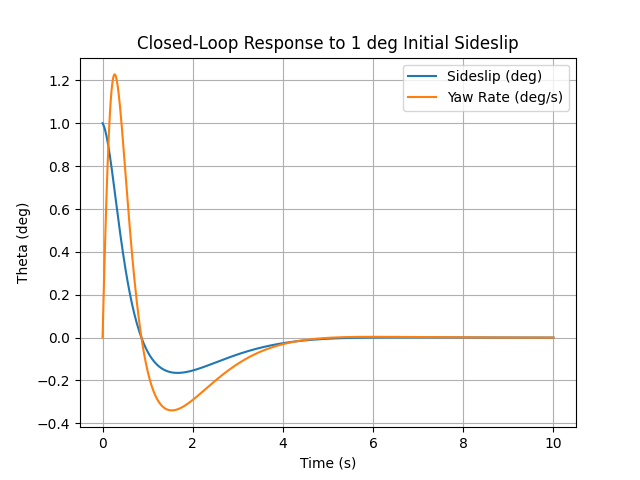

In [60]:
from scipy.signal import lsim, lti
acl = sys_cmd2latf.A - sys_cmd2latf.B @ K @ sys_cmd2latf.C

sys_final = lti(acl, sys_cmd2latf.B, sys_cmd2latf.C, sys_cmd2latf.D)
plt.figure()
time_def = np.linspace(0,10,1000)
X0_def = np.array([0, 0, 1/RTOD, 0, 0, 0, 0])  # 1 deg initial beta
t, y, _ = lsim(sys_final, np.zeros([2,len(time_def)]), T=time_def, X0=X0_def)
plt.plot(t, y[:,0])  # plot sideslip response
plt.plot(t, y[:,3])  # plot yaw rate response
plt.title('Closed-Loop Response to 1 deg Initial Sideslip')
plt.xlabel('Time (s)')
plt.ylabel('Theta (deg)')
plt.legend(['Sideslip (deg)', 'Yaw Rate (deg/s)'])
plt.grid()
plt.show()

#### Find K by different Means

In [ ]:
q_dr = 50
q_r = 50
Q = np.diag([0, 0, q_dr, q_r, q_r, q_dr, 1])

rho = 0.5
R = rho*np.eye(2)

K_0 = np.zeros([sys_cmd2latf.ninputs, sys_cmd2latf.noutputs])
# K_0[UA_IDX, PHI_IDX] = 0.1
K_0[UA_IDX, P_IDX] = -0.1 # dutch roll (roll rate)
K_0[UR_IDX, RW_IDX] = -1 # dutch roll (washed out yaw rate)
K_0[UA_IDX, PHI_IDX] = -0.1 # roll control
K_0[UR_IDX, BETA_IDX] = 0.5 # sideslip

from control_tools import lyapunov

def perf_index(sys, X, Q, R, K):
    Q_eff = sys.C.T @ K.T @ R @ K @ sys.C + Q
    P = lyapunov(sys.A - sys.B @ K @ sys.C, Q_eff)
    J = 0.5 * np.trace(P @ X)

    return J

J_test = perf_index(sys_cmd2latf, np.eye(sys_cmd2latf.nstates), Q, R, K)

from scipy.optimize import minimize
def objective(k_vec, sys, X, Q, R):
    K_mat = k_vec.reshape(sys.ninputs, sys.noutputs)
    J_val = perf_index(sys, X, Q, R, K_mat)
    return J_val

k0 = K.flatten()
res = minimize(objective, k0, args=(sys_cmd2latf, np.eye(sys_cmd2latf.nstates), Q, R))
k_opt = res.x

K_opt = k_opt.reshape(sys_cmd2latf.ninputs, sys_cmd2latf.noutputs)
J_opt = perf_index(sys_cmd2latf, np.eye(sys_cmd2latf.nstates), Q, R, K_opt)
print('J_opt =', J_opt)
print('K_opt =\n', K_opt)
     

J_opt = 1169.9339229952066
K_opt =
 [[ 0.46284966 -0.07101274 -0.07692607 -0.17882762]
 [-0.62675166 -0.13414603 -0.53108764 -0.96618714]]


C:\Users\jehen\AppData\Local\Temp\ipykernel_16084\3479592043.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


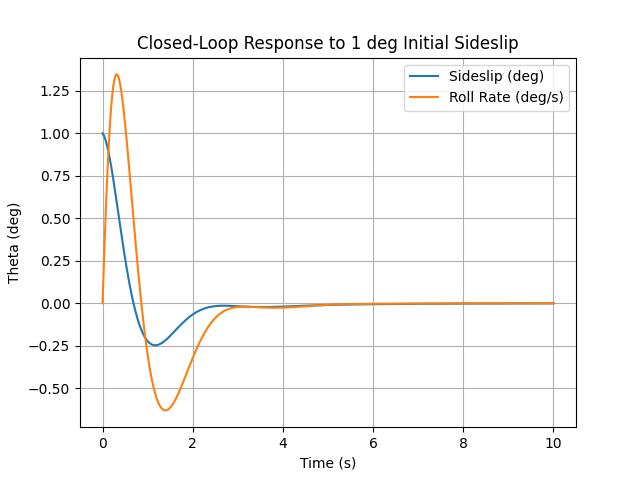

In [77]:
from scipy.signal import lsim, lti
acl = sys_cmd2latf.A - sys_cmd2latf.B @ K_opt @ sys_cmd2latf.C

sys_final = lti(acl, sys_cmd2latf.B, sys_cmd2latf.C, sys_cmd2latf.D)
plt.figure()
time_def = np.linspace(0,10,1000)
X0_def = np.array([0, 0, 1/RTOD, 0, 0, 0, 0])  # 1 deg initial beta
t, y, _ = lsim(sys_final, np.zeros([2,len(time_def)]), T=time_def, X0=X0_def)
plt.plot(t, y[:,0])  # plot sideslip response
plt.plot(t, y[:,3])  # plot yaw rate response
plt.title('Closed-Loop Response to 1 deg Initial Sideslip')
plt.xlabel('Time (s)')
plt.ylabel('Theta (deg)')
plt.legend(['Sideslip (deg)', 'Roll Rate (deg/s)'])
plt.grid()
plt.show()

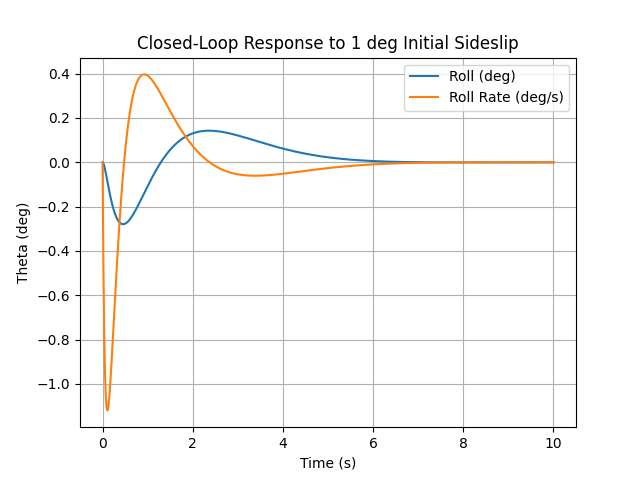

In [71]:
plt.figure()
plt.plot(t, y[:,1])  # plot roll response
plt.plot(t, y[:,2])  # plot roll rate response
plt.title('Closed-Loop Response to 1 deg Initial Sideslip')
plt.xlabel('Time (s)')
plt.ylabel('Theta (deg)')
plt.legend(['Roll (deg)', 'Roll Rate (deg/s)'])
plt.grid()
plt.show()